In [3]:
import re
import numpy as np
import time
import os.path
import sys
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from io import StringIO
#from Bio import SeqIO
#import pysam
from pandas.plotting import scatter_matrix
import warnings
import json
import numpy as np
import subprocess
from collections import OrderedDict
warnings.filterwarnings('ignore')
sys.executable.split('/')[-3]

'blastasm'

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [5]:
def refstats_df(mapped_names, alb_abbr, aln_ext, aln_params):
    #mp_hu_mus_megahit_default_toss_refstats.txt
    frames=[]
    g_names=[]
    for sra in SRAs:
        ref_path=BASE_PATH+f'{sra}/seal/'
        ref_file=f'{alb_abbr}_{aln_ext}_{aln_params}_refstats.txt'
        f = open(ref_path+ref_file, "r")
        lines=f.readlines()
        reads=[]
        for l in lines:
            for mn in mapped_names:
                if l.startswith(mn):
                    g_names.append(mn)
                    reads.append(l.split()[5])
        sra_l=[sra]*len(mapped_names)
        g_names=list(OrderedDict.fromkeys(g_names))
        df = pd.DataFrame(list(zip(sra_l, g_names, reads)),
               columns =['SRA', 'Name', 'Reads'])
        frames.append(df)
    #ref_df = pd.concat(frames)
    return frames

In [6]:
def plot_4_stackplots(df):
    df.plot(
      x = 'Name', 
      kind = 'bar', 
      stacked = True, 
      title = 'Percentage Stacked Bar Graph', 
      mark_right = True)

    df_total = df["human"] + df["vero"] + df["manjav"]+ df["sus"]
    df_rel = df[df.columns[1:]].div(df_total, 0)*100

    for n in df_rel:
        for i, (cs, ab, pc) in enumerate(zip(df.iloc[:, 1:].cumsum(1)[n], 
                                             df[n], df_rel[n])):
            plt.text(cs - ab / 2, i, str(np.round(pc, 1)) + '%', 
                     va = 'center', ha = 'center')

In [7]:
def get_pct(y_arr, tot_arr):
    pct_arr=[]
    for i,val in enumerate(y_arr.tolist()):
        #print(f'i: {i}, val: {val}')
        pct=(val/tot_arr[i])*100
        pct_arr.append(pct)
    pct_arr=np.array(pct_arr)
    return pct_arr

In [8]:
def plot_generator(plot_data,sra_totals, y_scale):
    y0=np.array(plot_data[0])
    y1=np.array(plot_data[1])
    y2=np.array(plot_data[2])
    if len(plot_data)==4:
        y3=np.array(plot_data[3])
    y4=None
    if y_scale=='normalized':
        y0=get_pct(y0, sra_totals)
        y1=get_pct(y1, sra_totals)
        y2=get_pct(y2, sra_totals)
        if len(plot_data)==4:
            y3=get_pct(y3, sra_totals)
    ymax=0

    if len(mapped_names)==5:
        y4=np.array(l_other)
        if y_scale=='normalized':
            y4=get_pct(y4, sra_totals)
        for l in zip(l_manjav,l_sus,l_human,l_vero,l_other):
            mx=max(l)
            if mx>ymax: ymax=mx
    else:
        if len(plot_data)==4:
            for l in zip(plot_data[0],plot_data[1],plot_data[2],plot_data[3]):
                mx=max(l)
                if mx>ymax: ymax=mx
            else:
                for l in zip(plot_data[0],plot_data[1],plot_data[2]):
                    mx=max(l)
                    if mx>ymax: ymax=mx
                
    
    ymax=ymax+ymax/7
    ymax -= ymax % -100  # Round x up to next multiple of 100.
    if len(plot_data)==4:
        return y0,y1,y2,y3,ymax
    else:
        return y0,y1,y2,ymax
    

In [9]:
def plot_flagtools_stackplots(frames, file_name, mapped_names, title, y_scale='log', fig_width=12, save_fig=True):
    #SRA 	mapped 	properly paired 	aln_ref
    #human, mouse, manjav
    l_human=[]
    l_mouse=[]
    l_manjav=[]
    l_manpten=[]
    l_other=[]
    sra_totals=[]
    #mapped_names=['YNU_ManJav_2.0','GRCh38','GRCm39', 'YNU_ManPten_2.0']
    for i, df in enumerate(frames):
        h=int(df.loc[df.Name == 'GRCh38','Reads'].values[0])
        l_human.append(h)
        m=int(df.loc[df.Name == 'GRCm39','Reads'].values[0])
        l_mouse.append(m)
        mj=int(df.loc[df.Name == 'YNU_ManJav_2.0','Reads'].values[0])
        l_manjav.append(mj)
        mp=int(df.loc[df.Name == 'YNU_ManPten_2.0','Reads'].values[0])
        l_manpten.append(mp)
        sra_totals.append(h+m+mj+mp)
        if len(mapped_names)==5:
            o=int(df.loc[df.Name == 'shrimp','Reads'].values[0])
            l_other.append(o)
            sra_totals[-1]=sra_totals[-1]+o
        sra=df['SRA'].iloc[0]
        assert sra==SRAs[i]

    y0,y1,y2,y3,y4,ymax=plot_generator(l_manjav,l_manpten,l_human,l_mouse,l_other,sra_totals, y_scale)
    y0n,y1n,y2n,y3n,y4n,ymaxn=plot_generator(l_manjav,l_manpten,l_human,l_mouse,l_other,sra_totals, y_scale='normalized')
    legend_order=['ManJav','ManPten', 'human', 'mouse', 'shrimp']
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(fig_width, 6))
    #plt.rcParams["figure.figsize"] = (fig_width,6)
    axes[0].bar(SRAs, y0, color='#FAC748')
    axes[0].bar(SRAs, y1, bottom=y0, color='skyblue') 
    axes[0].bar(SRAs, y2, bottom=y0+y1, color='#1D2F6F')
    axes[0].bar(SRAs, y3, bottom=y0+y1+y2, color='#6EAF46')
    if len(mapped_names)==5:
        axes[0].bar(SRAs, y4, bottom=y0+y1+y2+y3, color='indianred')
    axes[0].set_ylabel('counts')
    if y_scale=='log':
        axes[0].set_yscale('log')
    elif y_scale=='linear':
        axes[0].set_ylim(0,ymax)
    axes[0].legend(legend_order)

    axes[0].tick_params(axis='x', rotation=90)
    #axes[0].set_title(title, loc='left')

    axes[1].bar(SRAs, y0n, color='#FAC748')
    axes[1].bar(SRAs, y1n, bottom=y0n, color='skyblue') 
    axes[1].bar(SRAs, y2n, bottom=y0n+y1n, color='#1D2F6F')
    axes[1].bar(SRAs, y3n, bottom=y0n+y1n+y2n, color='#6EAF46')
    if len(mapped_names)==5:
        axes[1].bar(SRAs, y4n, bottom=y0n+y1n+y2n+y3n, color='indianred')
    axes[1].set_ylabel('percentage')
    axes[1].set_ylim(0,100)
    axes[1].legend(legend_order)
    
    axes[1].tick_params(axis='x', rotation=90)
    plt.title(title, x=0.1, y=1.02)
    fig.tight_layout()
    if save_fig:
        plt.savefig(f'{BASE_PATH}/general_plots/{file_name}', bbox_inches='tight')

In [10]:
def plot_flagtools_single_stackplots(frames, file_name, mapped_names, abbreviations, title, y_scale='log', fig_width=12, save_fig=False):
    #SRA 	mapped 	properly paired 	aln_ref
    #human, mouse, manjav
    l_d0=[]
    l_d1=[]
    l_d2=[]
    l_d3=[]
    sra_totals=[]
    df_cols=abbreviations.copy().insert(0, 'SRA')
    #mapped_names=['YNU_ManJav_2.0','GRCh38','GRCm39', 'YNU_ManPten_2.0']
    for i, df in enumerate(frames):
        d0=int(df.loc[df.Name == mapped_names[0],'Reads'].values[0])
        l_d0.append(d0)
        d1=int(df.loc[df.Name == mapped_names[1],'Reads'].values[0])
        l_d1.append(d1)
        d2=int(df.loc[df.Name == mapped_names[2],'Reads'].values[0])
        l_d2.append(d2)
        if len(mapped_names)==4:
            d3=int(df.loc[df.Name == mapped_names[3],'Reads'].values[0])
            l_d3.append(d3)
            sra_totals.append(d0+d1+d2+d3)
        else:
            sra_totals.append(d0+d1+d2)
        #if len(mapped_names)==5:
            #o=int(df.loc[df.Name == 'shrimp','Reads'].values[0])
            #l_other.append(o)
            #sra_totals[-1]=sra_totals[-1]+o
        sra=df['SRA'].iloc[0]
        assert sra==SRAs[i]
    if len(mapped_names)==4:
        if y_scale=='normalized':
            y0,y1,y2,y3,ymaxn=plot_generator([l_d0,l_d1,l_d2,l_d3],sra_totals, y_scale='normalized')
        else:
            y0,y1,y2,y3,ymax=plot_generator([l_d0,l_d1,l_d2,l_d3],sra_totals, y_scale)
        legend_order=abbreviations

        #save the df
        df=pd.DataFrame(list(zip(SRAs, y0.tolist(),y1.tolist(),y2.tolist(),y3.tolist())),
                  columns=df_cols)
        print(f'saving to {file_name}_df.csv')
        df.to_csv(f'{BASE_PATH}/general_plots/{file_name}_df.csv', index=False)


        #fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(fig_width, 6))
        plt.rcParams["figure.figsize"] = (fig_width,6)
        plt.bar(SRAs, y0, color='#FAC748')
        plt.bar(SRAs, y1, bottom=y0, color='skyblue') 
        plt.bar(SRAs, y2, bottom=y0+y1, color='#1D2F6F')
        plt.bar(SRAs, y3, bottom=y0+y1+y2, color='#6EAF46')
        if len(mapped_names)==5:
            plt.bar(SRAs, y4, bottom=y0+y1+y2+y3, color='indianred')
    else:
        if y_scale=='normalized':
            y0,y1,y2,ymaxn=plot_generator([l_d0,l_d1,l_d2],sra_totals, y_scale='normalized')
        else:
            y0,y1,y2,ymax=plot_generator([l_d0,l_d1,l_d2],sra_totals, y_scale)
        legend_order=abbreviations

        #save the df
        df=pd.DataFrame(list(zip(SRAs, y0.tolist(),y1.tolist(),y2.tolist())),
                  columns=df_cols)
        print(f'saving to {file_name}_df.csv')
        df.to_csv(f'{BASE_PATH}/general_plots/{file_name}_df.csv', index=False)


        #fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(fig_width, 6))
        plt.rcParams["figure.figsize"] = (fig_width,6)
        plt.bar(SRAs, y0, color='#FAC748')
        plt.bar(SRAs, y1, bottom=y0, color='skyblue') 
        plt.bar(SRAs, y2, bottom=y0+y1, color='#1D2F6F')

    plt.ylabel('percent')
    if y_scale=='log':
        plt.yscale('log')
    elif y_scale=='linear':
        plt.ylim(0,ymax)
    plt.legend(legend_order, loc=(1.05, 0.7))
    ax = plt.axes()
    ax.set_xticklabels(SAMPLES)
    plt.tick_params(axis='x', rotation=90)
    #axes[0].set_title(title, loc='left')

    plt.title(title)
    plt.tight_layout()
    if save_fig:
        plt.savefig(f'{BASE_PATH}/general_plots/{file_name}', bbox_inches='tight')

## Genomes

In [12]:
def plot_concatref(df, file_name, mapped_names, title, y_scale='log', fig_width=12, save_fig=False):
    
    sras=[]
    sus_pcts=[]
    mj_pcts=[]
    names=[]
    for row in df.itertuples():
        print(row)
        sra = row[1]
        idx=SRAs.index(sra)
        name=SAMPLES[idx]
        sus= row[2]
        mj = row[3]

        total=sus+mj
        pct_sus=(sus/total)*100
        pct_mj=(mj/total)*100
        names.append(name)
        sus_pcts.append(pct_sus)
        mj_pcts.append(pct_mj)
        sras.append(sra)
        #print(sra)
        #print(pct_sus)
        #print(pct_mj)
        
    y0=np.array(sus_pcts)
    y1=np.array(mj_pcts)


    legend_order=abbreviations

    #fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(fig_width, 6))
    plt.rcParams["figure.figsize"] = (fig_width,6)
    plt.bar(sras, y0, color='#FAC748')
    plt.bar(sras, y1, bottom=y0, color='skyblue') 


    plt.ylabel('percent')
    if y_scale=='log':
        plt.yscale('log')
    elif y_scale=='linear':
        plt.ylim(0,105)
    plt.legend(legend_order, loc=(1.05, 0.7))
    ax = plt.axes()
    ax.set_xticklabels(names)
    plt.tick_params(axis='x', rotation=90)


    plt.title(title)
    plt.tight_layout()
    if save_fig:
        plt.savefig(f'{BASE_PATH}/general_plots/{file_name}', bbox_inches='tight')

In [13]:
#human
REF_NAME_H='GRCh38.p13.fna'

#pig
REF_NAME_S='Sscrofa11.1.fna'

#Vero cell
REF_NAME_V='Vero_WHO_p1.0.fna'

#YNU_ManJav_2.0 (Pangolin)
REF_NAME_MJ='YNU_ManJav_2.0.fna'

#Manis p
REF_NAME_MP='YNU_ManPten_2.0.fna'

#cat
REF_NAME_C='Fca126_mat1.0.fna'

#goat
REF_NAME_G='CapAeg_1.0.fna'

#bamboo rat
REF_NAME_R='RhiPru_1.0.fna'


## PRJNA901878 - GX-HKU4

In [10]:


#REF_LIST=[REF_NAME_S, REF_NAME_MJ, REF_NAME_H, REF_NAME_V]

#for storing in filename
REF_UID="YNU_ManJav_2.0_Sscrofa11.1_GRCh38_Vero"

MATCH='unique'

AMBIG='toss'


mapped_names=['Sscrofa11.1', 'YNU_ManJav_2.0', 'GRCh38.p13', 'Vero_WHO_p1.0']
abbreviations=['Sus scrofa', 'Manis javanica', 'Homo sapiens', 'Vero']

In [11]:
#alb_abbr='sus_mj'
ALN_ABBR='YNU_ManJav_2.0_Sscrofa11.1_GRCh38_Vero'
ALN_EXT='MKF0.3_MKH3'
ALN_PARAMS='toss'
ALN_TYPE='reads'

In [94]:
PRJ='PRJNA901878'
BASE_PATH = f'/mnt/8TB_2/Data/Assembly/{PRJ}/'

In [13]:
SRAs=['SRR22936419','SRR22936420','SRR22936421','SRR22936422', 'SRR22936541','SRR22936544', 'SRR22936770', 'SRR22936773']
SAMPLES=['PPeV-GX', 'HKU4-GX','P79-9', 'P70-9','M5-9','P44-9','FL16', 'FL13']

In [14]:
#save out semi proc data
frames=refstats_df(mapped_names, ALN_ABBR, ALN_EXT, ALN_PARAMS)
ref_df = pd.concat(frames)
ref_df.to_csv(f'{BASE_PATH}/general_plots/mj_sus_8_datasets_Seal_stats.csv')

saving to seal_toss_reads_YNU_ManJav_2.0_Sscrofa11.1_GRCh38_Vero_normalized.png_df.csv


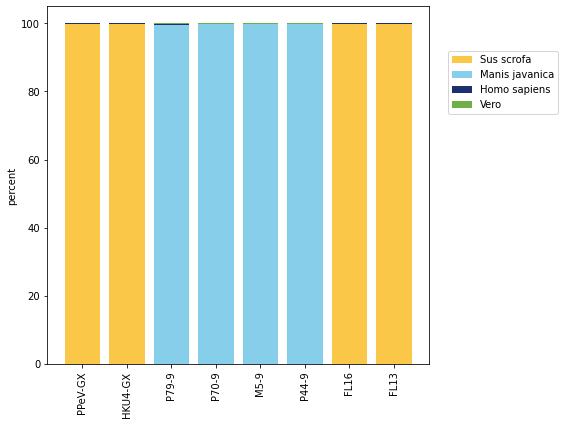

In [15]:
y_scale='normalized'
y_scale_txt = y_scale.replace("'", "")
file_name=f'seal_{ALN_PARAMS}_{ALN_TYPE}_{ALN_ABBR}_{y_scale_txt}.png'

#title=f"Seal: ManJav, ManPten, Human, Mouse [ambiguous={aln_params.split('_')[1]}], {y_scale_txt} and normalized scales"
#plot_flagtools_stackplots(frames, file_name, mapped_names, title, y_scale=y_scale, fig_width=12, save_fig=True)

#title=f"Seal: [ambiguous={ALN_PARAMS}], {y_scale_txt} scale"
title=''
plot_flagtools_single_stackplots(frames, file_name, mapped_names, abbreviations, title, y_scale=y_scale, fig_width=len(SAMPLES), save_fig=False)

In [17]:
df_concatref=pd.read_csv(f'{BASE_PATH}/general_plots/sus_mj_concat_ref_stats.csv')

In [19]:
SRAs=['SRR22936419','SRR22936420','SRR22936421','SRR22936422', 'SRR22936541','SRR22936544', 'SRR22936770', 'SRR22936773']
SAMPLES=['PPeV-GX', 'HKU4-GX','P79-9', 'P70-9','M5-9','P44-9','FL16', 'FL13']

df_concatref.head(n=10)

,SRA,Sus scrofa,MJ,min quality,MJ percentage
0,SRR22936419,37180600,116686,20,0.312854
1,SRR22936420,130445860,360629,20,0.275697
2,SRR22936421,473838,79115536,20,99.404647
3,SRR22936422,399163,80895447,20,99.508992
4,SRR22936541,314506,81167913,20,99.614020
5,SRR22936544,543296,77834081,20,99.306820
6,SRR22936770,57430494,42903,20,0.074648
7,SRR22936773,48627934,51227,20,0.105234


Pandas(Index=0, SRA='SRR22936419', _2=37180600, MJ=116686, _4=20, _5=0.312853862878924)
Pandas(Index=1, SRA='SRR22936420', _2=130445860, MJ=360629, _4=20, _5=0.27569656731632003)
Pandas(Index=2, SRA='SRR22936421', _2=473838, MJ=79115536, _4=20, _5=99.40464665546939)
Pandas(Index=3, SRA='SRR22936422', _2=399163, MJ=80895447, _4=20, _5=99.5089920475663)
Pandas(Index=4, SRA='SRR22936541', _2=314506, MJ=81167913, _4=20, _5=99.6140198046894)
Pandas(Index=5, SRA='SRR22936544', _2=543296, MJ=77834081, _4=20, _5=99.30682038517321)
Pandas(Index=6, SRA='SRR22936770', _2=57430494, MJ=42903, _4=20, _5=0.0746484499602486)
Pandas(Index=7, SRA='SRR22936773', _2=48627934, MJ=51227, _4=20, _5=0.10523394189148)


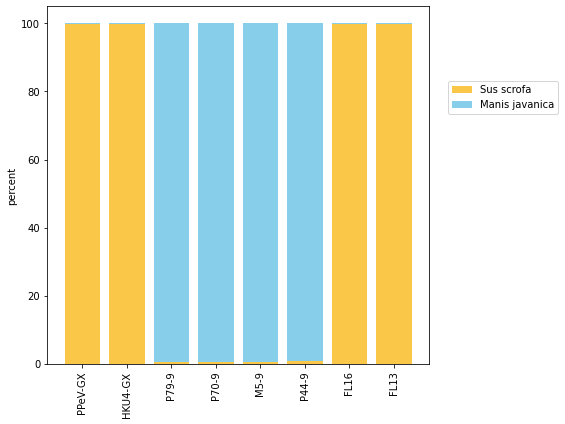

In [39]:
y_scale='normalized'
file_name=f'concatref_{ALN_PARAMS}_{ALN_TYPE}_{ALN_ABBR}_{y_scale_txt}.png'
title=''
plot_concatref(df_concatref, file_name, mapped_names, title, y_scale='linear', fig_width=len(SAMPLES), save_fig=True)

#### Bamboo Rat

In [11]:


#REF_LIST=[REF_NAME_S, REF_NAME_MJ, REF_NAME_H, REF_NAME_V]

#for storing in filename
REF_UID="RhiPru_1.0_Sscrofa11.1_GRCh38_Vero"

MATCH='unique'

AMBIG='toss'


mapped_names=['Sscrofa11.1', 'RhiPru_1.0', 'GRCh38.p13', 'Vero_WHO_p1.0']
abbreviations=['Sus scrofa', 'Rhizomys pruinosus', 'Homo sapiens', 'Vero']

In [12]:
#alb_abbr='sus_mj'
ALN_ABBR='RhiPru_1.0_Sscrofa11.1_GRCh38_Vero'
ALN_EXT='MKF0.3_MKH3'
ALN_PARAMS='toss'
ALN_TYPE='reads'

In [13]:
PRJ='PRJNA901878'
BASE_PATH = f'/mnt/8TB_2/Data/Assembly/{PRJ}/'

In [14]:
SRAs=['SRR22936497']
SAMPLES=['GX19-89']

In [15]:
#save out semi proc data
frames=refstats_df(mapped_names, ALN_ABBR, ALN_EXT, ALN_PARAMS)
ref_df = pd.concat(frames)
ref_df.to_csv(f'{BASE_PATH}/general_plots/SRR22936497_Seal_stats.csv')

saving to seal_toss_reads_RhiPru_1.0_Sscrofa11.1_GRCh38_Vero_normalized.png_df.csv


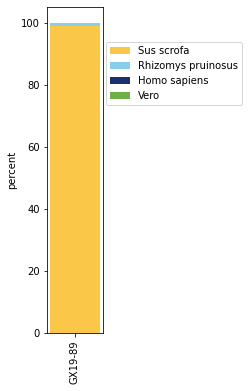

In [59]:
y_scale='normalized'
y_scale_txt = y_scale.replace("'", "")
file_name=f'seal_{ALN_PARAMS}_{ALN_TYPE}_{ALN_ABBR}_{y_scale_txt}.png'

#title=f"Seal: ManJav, ManPten, Human, Mouse [ambiguous={aln_params.split('_')[1]}], {y_scale_txt} and normalized scales"
#plot_flagtools_stackplots(frames, file_name, mapped_names, title, y_scale=y_scale, fig_width=12, save_fig=True)

#title=f"Seal: [ambiguous={ALN_PARAMS}], {y_scale_txt} scale"
title=''
plot_flagtools_single_stackplots(frames, file_name, mapped_names, abbreviations, title, y_scale=y_scale, fig_width=len(SAMPLES), save_fig=True)

In [42]:
#REF_LIST=[REF_NAME_S, REF_NAME_MJ, REF_NAME_H, REF_NAME_V]

#for storing in filename
REF_UID="RhiPru_1.0_Sscrofa11.1"

MATCH='unique'

AMBIG='toss'


mapped_names=['Sscrofa11.1', 'RhiPru_1.0']
abbreviations=['Sus scrofa', 'Rhizomys pruinosus']

In [43]:
#alb_abbr='sus_mj'
ALN_ABBR='RhiPru_1.0_Sscrofa11.1'
ALN_EXT='MKF0.3_MKH3'
ALN_PARAMS='toss'
ALN_TYPE='reads'

In [44]:
df_concat_rp=pd.read_csv(f'{BASE_PATH}/general_plots/sus_rp_concat_ref_stats.csv')

In [45]:
SRAs=['SRR22936497']
SAMPLES=['GX19-89']

df_concat_rp.head()

,SRA,Sus scrofa,RP,min quality,RP percentage
0,SRR22936497,88118319,1010022,20,1.133222


Pandas(Index=0, SRA='SRR22936497', _2=88118319, RP=1010022, _4=20, _5=1.13322203540174)


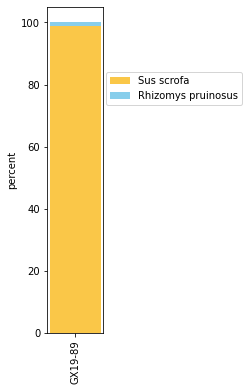

In [46]:
y_scale='normalized'
file_name=f'concatref_{ALN_PARAMS}_{ALN_TYPE}_{ALN_ABBR}_{y_scale_txt}.png'
title=''
plot_concatref(df_concat_rp, file_name, mapped_names, title, y_scale='linear', fig_width=len(SAMPLES), save_fig=True)

## PRJCA002517 - MjHKU4-CoV-1-4

In [47]:


#REF_LIST=[REF_NAME_S, REF_NAME_MJ, REF_NAME_H, REF_NAME_V]

#for storing in filename
REF_UID="YNU_ManJav_2.0_GRCh38_Vero"

MATCH='unique'

AMBIG='toss'


mapped_names=['YNU_ManJav_2.0', 'GRCh38.p13', 'Vero_WHO_p1.0']
abbreviations=['Manis javanica', 'Homo sapiens', 'Vero']

In [48]:
#alb_abbr='sus_mj'
ALN_ABBR='YNU_ManJav_2.0_GRCh38_Vero'
ALN_EXT='MKF0.3_MKH3'
ALN_PARAMS='toss'
ALN_TYPE='reads'

In [49]:
PRJ='PRJCA002517'
BASE_PATH=f'/mnt/8TB_2/Data/Assembly/{PRJ}/'

In [50]:
SRAs=['CRR477154','CRR477155','CRR477156','CRR477157']
SAMPLES=['A96', 'A97','A98','A100']

In [67]:
#alternatively run with no sus scrofa
#ALN_ABBR='YNU_ManJav_2.0_GRCh38_Vero'

frames=refstats_df(mapped_names, ALN_ABBR, ALN_EXT, ALN_PARAMS)
ref_df = pd.concat(frames)
#ref_df.to_csv(f'{BASE_PATH}/general_plots/PRJNA573298_Seal_fig5_02052022.csv')

saving to seal_toss_reads_YNU_ManJav_2.0_GRCh38_Vero_normalized.png_df.csv


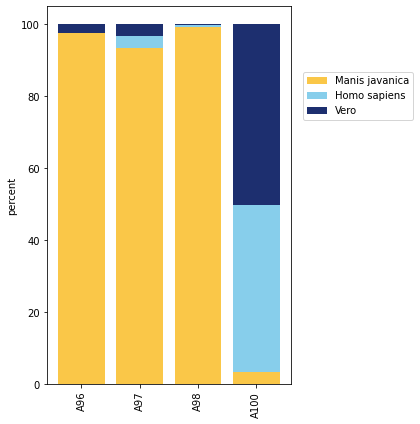

In [69]:
y_scale='normalized'
y_scale_txt = y_scale.replace("'", "")
file_name=f'seal_{ALN_PARAMS}_{ALN_TYPE}_{ALN_ABBR}_{y_scale_txt}.png'

#title=f"Seal: ManJav, ManPten, Human, Mouse [ambiguous={aln_params.split('_')[1]}], {y_scale_txt} and normalized scales"
#plot_flagtools_stackplots(frames, file_name, mapped_names, title, y_scale=y_scale, fig_width=12, save_fig=True)

#title=f"Seal: [ambiguous={ALN_PARAMS}], {y_scale_txt} scale"
title=''
plot_flagtools_single_stackplots(frames, file_name, mapped_names, abbreviations, title, y_scale=y_scale, fig_width=len(SAMPLES)*1.5, save_fig=True)

In [95]:
def plot_concatref3(df, file_name, mapped_names, title, legend_order, y_scale='log', fig_width=12, save_fig=False):
    
    sras=[]
    vero_pcts=[]
    mj_pcts=[]
    hs_pcts=[]
    names=[]
    for row in df.itertuples():
        sra = row[1]
        idx=SRAs.index(sra)
        name=SAMPLES[idx]
        vero= row[2]
        mj = row[3]
        hs = row[4]
        total=vero+mj+hs
        pct_v=(vero/total)*100
        pct_mj=(mj/total)*100
        pct_hs=(hs/total)*100
        names.append(name)
        vero_pcts.append(pct_v)
        mj_pcts.append(pct_mj)
        hs_pcts.append(pct_hs)
        sras.append(sra)
        
    y0=np.array(mj_pcts)
    y1=np.array(hs_pcts)
    y2=np.array(vero_pcts)

    #fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(fig_width, 6))
    plt.rcParams["figure.figsize"] = (fig_width,6)
    plt.bar(sras, y0, color='#FAC748')
    plt.bar(sras, y1, bottom=y0, color='skyblue') 
    plt.bar(sras, y2, bottom=y0+y1, color='#1D2F6F')


    plt.ylabel('percent')
    if y_scale=='log':
        plt.yscale('log')
    elif y_scale=='linear':
        plt.ylim(0,105)
    plt.legend(legend_order, loc=(1.05, 0.7))
    ax = plt.axes()
    ax.set_xticklabels(names)
    plt.tick_params(axis='x', rotation=90)


    plt.title(title)
    plt.tight_layout()
    if save_fig:
        plt.savefig(f'{BASE_PATH}/general_plots/{file_name}', bbox_inches='tight')

In [96]:
df_concatref=pd.read_csv(f'{BASE_PATH}/general_plots/v_mj_hu_concat_ref_stats.csv')

In [97]:
SRAs=['CRR477154','CRR477155','CRR477156','CRR477157']
SAMPLES=['A96', 'A97','A98','A100']

df_concatref.head(n=10)

,SRA,Vero,MJ,HS,min quality,MJ percentage
0,CRR477154,1127064,86045523,34158,20,98.668426
1,CRR477155,882926,27410251,1000660,20,93.570026
2,CRR477156,248833,88326100,315739,20,99.364869
3,CRR477157,2364622,165666,2260338,20,3.458128


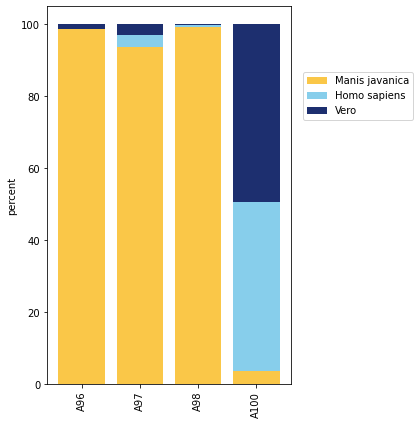

In [98]:
y_scale='normalized'
file_name=f'concatref_{ALN_PARAMS}_{ALN_TYPE}_{ALN_ABBR}_{y_scale_txt}.png'
title=''
legend_order=['Manis javanica', 'Homo sapiens', 'Vero']
plot_concatref3(df_concatref, file_name, mapped_names, title, legend_order, y_scale='linear', fig_width=len(SAMPLES)*1.5, save_fig=True)

#### With sus scrofa


In [70]:
mapped_names=['Sscrofa11.1','YNU_ManJav_2.0',  'GRCh38.p13', 'Vero_WHO_p1.0']
abbreviations=['Sus scrofa', 'Manis javanica', 'Homo sapiens', 'Vero']
ALN_ABBR='YNU_ManJav_2.0_Sscrofa11.1_GRCh38_Vero'

frames=refstats_df(mapped_names, ALN_ABBR, ALN_EXT, ALN_PARAMS)
ref_df = pd.concat(frames)
#ref_df.to_csv(f'{BASE_PATH}/general_plots/PRJNA573298_Seal_fig5_02052022.csv')

saving to seal_toss_reads_YNU_ManJav_2.0_Sscrofa11.1_GRCh38_Vero_normalized.png_df.csv


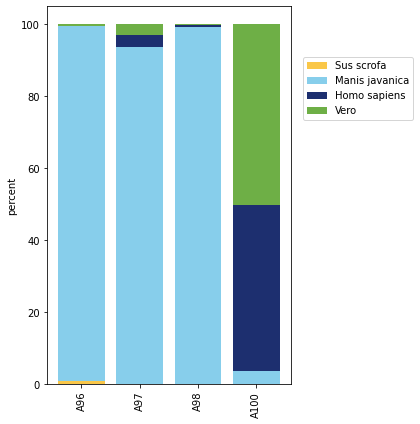

In [72]:
y_scale='normalized'
y_scale_txt = y_scale.replace("'", "")
file_name=f'seal_{ALN_PARAMS}_{ALN_TYPE}_{ALN_ABBR}_{y_scale_txt}.png'

#title=f"Seal: ManJav, ManPten, Human, Mouse [ambiguous={aln_params.split('_')[1]}], {y_scale_txt} and normalized scales"
#plot_flagtools_stackplots(frames, file_name, mapped_names, title, y_scale=y_scale, fig_width=12, save_fig=True)

#title=f"Seal: [ambiguous={ALN_PARAMS}], {y_scale_txt} scale"
title=''
plot_flagtools_single_stackplots(frames, file_name, mapped_names, abbreviations, title, y_scale=y_scale, fig_width=len(SAMPLES)*1.5, save_fig=True)

## PRJNA845961 - P251T  - wait for MT alignments then re-reun on more

In [85]:
PRJ='PRJNA845961'
BASE_PATH=f'/mnt/8TB_1/Data/Assembly/{PRJ}/'

In [37]:
SRAs=['SRR19632971','SRR19633001']
SAMPLES=['P251T', 'P219T']

In [38]:
mapped_names=['YNU_ManJav_2.0', 'GRCh38.p13', 'Vero_WHO_p1.0']
abbreviations=['Manis javanica', 'Homo sapiens', 'Vero']
ALN_ABBR='YNU_ManJav_2.0_GRCh38_Vero'


#save out semi proc data
frames=refstats_df(mapped_names, ALN_ABBR, ALN_EXT, ALN_PARAMS)
ref_df = pd.concat(frames)
#ref_df.to_csv(f'{BASE_PATH}/general_plots/PRJNA573298_Seal_fig5_02052022.csv')

saving to seal_toss_reads_YNU_ManJav_2.0_GRCh38_Vero_normalized.png_df.csv


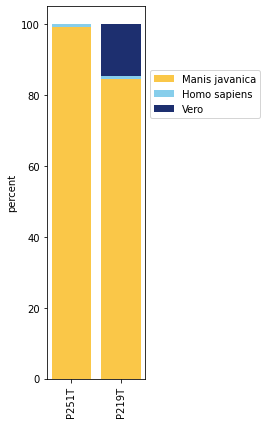

In [40]:
y_scale='normalized'
y_scale_txt = y_scale.replace("'", "")
file_name=f'seal_{ALN_PARAMS}_{ALN_TYPE}_{ALN_ABBR}_{y_scale_txt}.png'

#title=f"Seal: ManJav, ManPten, Human, Mouse [ambiguous={aln_params.split('_')[1]}], {y_scale_txt} and normalized scales"
#plot_flagtools_stackplots(frames, file_name, mapped_names, title, y_scale=y_scale, fig_width=12, save_fig=True)

#title=f"Seal: [ambiguous={ALN_PARAMS}], {y_scale_txt} scale"
title=''
plot_flagtools_single_stackplots(frames, file_name, mapped_names, abbreviations, title, y_scale=y_scale, fig_width=len(SAMPLES)*1.5, save_fig=True)

saving to seal_toss_reads_YNU_ManJav_2.0_mChoDid1_GRCh38_Vero_normalized.png_df.csv


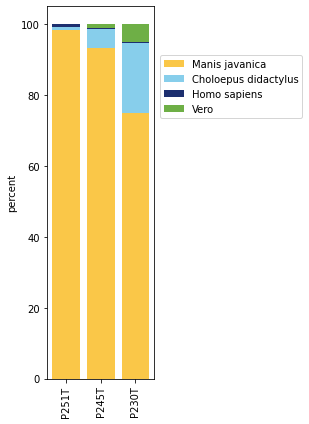

In [86]:
SRAs=['SRR19632971', 'SRR19632976', 'SRR19632991']
SAMPLES=['P251T', 'P245T', 'P230T']


#for storing in filename
REF_UID="YNU_ManJav_2.0_mChoDid1_GRCh38_Vero"

mapped_names=['YNU_ManJav_2.0', 'mChoDid1.pri', 'GRCh38.p13', 'Vero_WHO_p1.0']
abbreviations=['Manis javanica', 'Choloepus didactylus', 'Homo sapiens', 'Vero']
ALN_ABBR="YNU_ManJav_2.0_mChoDid1_GRCh38_Vero"


#save out semi proc data
frames=refstats_df(mapped_names, ALN_ABBR, ALN_EXT, ALN_PARAMS)
ref_df = pd.concat(frames)
#ref_df.to_csv(f'{BASE_PATH}/general_plots/PRJNA573298_Seal_fig5_02052022.csv')
y_scale='normalized'
y_scale_txt = y_scale.replace("'", "")
file_name=f'seal_{ALN_PARAMS}_{ALN_TYPE}_{ALN_ABBR}_{y_scale_txt}.png'

#title=f"Seal: ManJav, ManPten, Human, Mouse [ambiguous={aln_params.split('_')[1]}], {y_scale_txt} and normalized scales"
#plot_flagtools_stackplots(frames, file_name, mapped_names, title, y_scale=y_scale, fig_width=12, save_fig=True)

#title=f"Seal: [ambiguous={ALN_PARAMS}], {y_scale_txt} scale"
title=''
plot_flagtools_single_stackplots(frames, file_name, mapped_names, abbreviations, title, y_scale=y_scale, fig_width=len(SAMPLES)*1.5, save_fig=True)

## PRJNA747757 - HKU4-BGI-2020

In [79]:
REF_LIST=[REF_NAME_MJ, REF_NAME_G, REF_NAME_C]

#for storing in filename
REF_UID="CapAeg_1.0_YNU_ManJav_2.0_Fca126_mat1.0"

#'Sscrofa11.1',

MATCH='unique'

AMBIG='toss'

mapped_names=['CapAeg_1.0', 'YNU_ManJav_2.0', 'Fca126_mat1.0']
abbreviations=['Capra aegagrus', 'Manis javanica', 'Felis catus']

In [80]:
#alb_abbr='sus_mj'
ALN_ABBR='CapAeg_1.0_YNU_ManJav_2.0_Fca126_mat1.0'
ALN_EXT='MKF0.3_MKH3'
ALN_PARAMS='toss'
ALN_TYPE='reads'

In [81]:
PRJ='PRJNA747757'
BASE_PATH=f'/mnt/8TB_2/Data/Assembly/{PRJ}/'

In [82]:
SRAs=['SRR15199668','SRR15199672' , 'SRR15199667', 'SRR15199670', 'SRR15199671', 'SRR15199665', 'SRR15199666' , 'SRR15199663','SRR15199669',\
     'SRR15199675','SRR15199660','SRR15199676','SRR15199661','SRR15199664','SRR15199659']
SAMPLES=['PGN_LG', 'PGN_DM','PGN_LI','PGN_HT','PGN_ES','PGN_SH','PGN_LR', 'PGN_SN','PGN_KY','CT_ES','CT_LG','CT_ED','CT_KY','CT_HT','CT_LR']

In [83]:
#save out semi proc data
frames=refstats_df(mapped_names, ALN_ABBR, ALN_EXT, ALN_PARAMS)
ref_df = pd.concat(frames)
#ref_df.to_csv(f'{BASE_PATH}/general_plots/PRJNA573298_Seal_fig5_02052022.csv')

saving to seal_toss_reads_CapAeg_1.0_YNU_ManJav_2.0_Fca126_mat1.0_normalized.png_df.csv


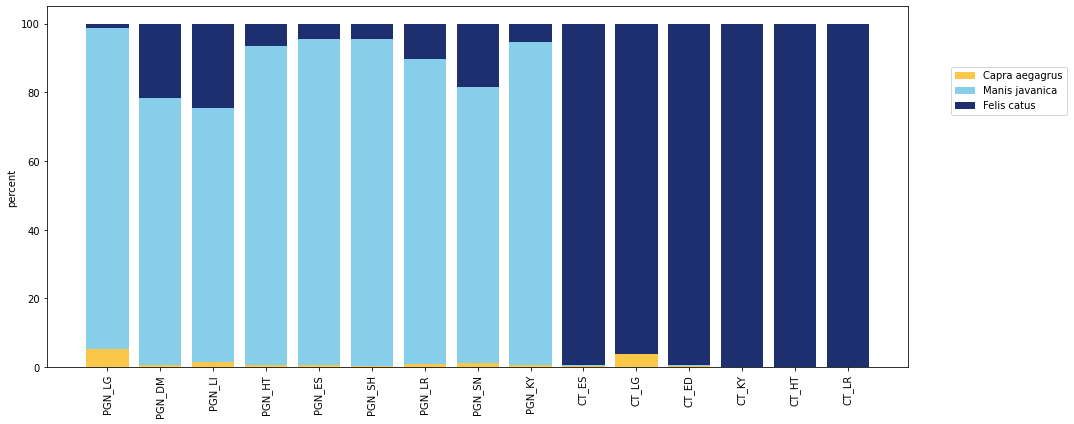

In [84]:
y_scale='normalized'
y_scale_txt = y_scale.replace("'", "")
file_name=f'seal_{ALN_PARAMS}_{ALN_TYPE}_{ALN_ABBR}_{y_scale_txt}.png'

#title=f"Seal: ManJav, ManPten, Human, Mouse [ambiguous={aln_params.split('_')[1]}], {y_scale_txt} and normalized scales"
#plot_flagtools_stackplots(frames, file_name, mapped_names, title, y_scale=y_scale, fig_width=12, save_fig=True)

#title=f"Seal: [ambiguous={ALN_PARAMS}], {y_scale_txt} scale"
title=''
plot_flagtools_single_stackplots(frames, file_name, mapped_names, abbreviations, title, y_scale=y_scale, fig_width=len(SAMPLES), save_fig=True)